# hp_file_extractor

## common

In [11]:
import os
import numpy as np
import pandas as pd
hp_config_format = ['liczba punktów', 'liczba warstw', 'liczba neuronów', 'funkcja aktywacji', 'warstwa wyjściowa']
# hp_stat_columns = ['hp_config','avg(test)','med(test)','std(test)','max(train)','min(train)']
hp_stat_columns = ['hp_config','med(train)','med(test)','std(test)']

def hp_config_split(dataframe):
    duplicates = dataframe[dataframe.duplicated(subset=['hp_config'])].copy()
    if duplicates.empty is False:
        print('duplicated hp_configs:', list(duplicates['hp_config']))
    dataframe = dataframe.copy()
    dataframe.drop_duplicates(subset=['hp_config'], inplace=True)
    dataframe[hp_config_format] = dataframe['hp_config'].str.rsplit('-', n=4, expand=True)
    return dataframe

def construct_df_from_history_files(history_dir, metric='loss', tail_size=25):
    # history_dir = DIRECTORY + 'history/'
    hp_file_rows = []
    history_filenames = list(filter(lambda filename: 'history' in filename, os.listdir(history_dir)))
    for history_filename in history_filenames:
        
        history_df = pd.read_csv(history_dir + history_filename)
        val_metric_tail = history_df[f'val_{metric}'][-tail_size:]
        metric_tail = history_df[f'{metric}'][-tail_size:]
        
        # new_row = {hp_stat_columns[0]:history_filename.rsplit('-', 1)[0],hp_stat_columns[1]:np.average(val_metric_tail),hp_stat_columns[2]:np.median(val_metric_tail),hp_stat_columns[3]:np.std(val_metric_tail),hp_stat_columns[4]:np.max(metric_tail),hp_stat_columns[5]:np.min(metric_tail)}
        new_row = {
            hp_stat_columns[0]: history_filename.rsplit('-', 1)[0],
            hp_stat_columns[1]:np.median(metric_tail),
            hp_stat_columns[2]:np.median(val_metric_tail),
            hp_stat_columns[3]:np.std(val_metric_tail)}
        hp_file_rows.append(new_row)

    hp_df = pd.DataFrame(hp_file_rows, columns=hp_stat_columns)
    hp_df = hp_config_split(hp_df)
    hp_df = hp_df[hp_config_format + hp_stat_columns[1:]]
    return hp_df

def hp_df_transform(df, metric='acc', sort_by='med(test)', ascending=False):
    df = df[~df['hp_config'].str.contains('selu')]
    
    df[['topologia sieci', 'funkcja aktywacji']] = df['hp_config'].str.rsplit('-', n=1, expand=True)
    df.rename(columns={f'val_{metric}-med': 'med(test)', f'train_{metric}-max': 'max(train)', f'val_{metric}-std': 'std(test)'}, inplace=True)
    df = df[['topologia sieci', 'funkcja aktywacji', 'max(train)', 'med(test)', 'std(test)']]

    df['topologia sieci'] = df['topologia sieci'].str.replace('-','x')
    df['funkcja aktywacji'] = df['funkcja aktywacji'].str.replace('_','\_')
    
    return df.sort_values(sort_by, ascending=ascending)

In [12]:
MAX_ROWS = 10
pd.set_option('display.max_rows', MAX_ROWS)

In [13]:
import sys
ABS_ROOT_DIR_PATH = '/home/rutkowski/dissertation/'
if ABS_ROOT_DIR_PATH not in sys.path:
    sys.path.append(ABS_ROOT_DIR_PATH)

## q

In [21]:
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/10points/history/', metric='accuracy')
df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
101,10,3,32,pol_tanh,softmax_real_with_abs,0.966029,0.964504,0.023713
86,10,3,64,pol_tanh,softmax_real_with_abs,0.968018,0.962668,0.017091
68,10,2,64,pol_sigmoid,softmax_real_with_abs,0.962969,0.958996,0.023373
46,10,2,32,pol_sigmoid,softmax_real_with_abs,0.966794,0.958996,0.030131
76,10,3,32,pol_sigmoid,softmax_of_softmax_real_with_mult,0.950727,0.958384,0.028837
89,10,3,64,pol_sigmoid,softmax_of_softmax_real_with_mult,0.950115,0.957160,0.022869
65,10,3,128,pol_sigmoid,softmax_real_with_abs,0.957001,0.954712,0.015684
3,10,2,128,pol_sigmoid,softmax_real_with_abs,0.960979,0.954100,0.013472
70,10,3,64,pol_sigmoid,sigmoid_real,0.955317,0.953488,0.039756
59,10,2,128,pol_tanh,softmax_real_with_abs,0.961438,0.953488,0.011027


In [15]:
# outputlayer_activation_func_space search
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/q/1700341579/history/', metric='accuracy')
df.sort_values('med(test)', ascending=False)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
1,10,2,128,pol_sigmoid,softmax_real_with_abs,0.964040,0.958996,0.020365
27,10,3,128,pol_tanh,softmax_real_with_abs,0.964958,0.957160,0.017923
33,10,2,128,pol_sigmoid,softmax_of_softmax_real_with_avg,0.953940,0.951652,0.015851
28,10,3,128,pol_sigmoid,softmax_real_with_abs,0.959296,0.951652,0.017881
8,10,3,128,pol_sigmoid,softmax_of_softmax_real_with_mult,0.952563,0.951040,0.019241
14,10,2,128,pol_tanh,softmax_real_with_mult,0.953481,0.949816,0.008933
20,10,3,128,pol_sigmoid,sigmoid_real,0.953787,0.949204,0.026063
41,10,3,128,pol_tanh,softmax_of_softmax_real_with_avg,0.956083,0.949204,0.029735
37,10,2,128,pol_sigmoid,softmax_of_softmax_real_with_mult,0.958378,0.949204,0.017468
31,10,3,128,pol_tanh,softmax_of_softmax_real_with_mult,0.955011,0.946144,0.018555


## phi

In [16]:
hp_df_transform(pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/phi/first/hp.csv'), metric='loss', ascending=True)
# print(hp_df.to_latex(index=False))

,topologia sieci,funkcja aktywacji,max(train),med(test),std(test)
1,3x1x32,pol\_sigmoid,0.005031,0.004447,0.001784
6,3x1x64,pol\_sigmoid,0.005271,0.005019,0.002429
20,3x2x32,pol\_tanh,0.005842,0.005190,0.002229
10,3x1x96,pol\_tanh,0.005154,0.005240,0.001499
30,3x2x96,pol\_tanh,0.005652,0.005262,0.002339
...,...,...,...,...,...
163,10x3x32,cart\_sigmoid,0.027048,0.029668,0.002541
143,10x2x32,cart\_sigmoid,0.028502,0.030368,0.001065
122,10x1x32,cart\_tanh,0.033277,0.032618,0.000933
162,10x3x32,cart\_tanh,0.032770,0.033443,0.001447


## pt

In [17]:
df = construct_df_from_history_files(ABS_ROOT_DIR_PATH + 'trained_models/pt/1to10-raw/history/', metric='mean_absolute_percentage_error', tail_size=25)
df.sort_values('med(test)', ascending=True)[:MAX_ROWS]

,liczba punktów,liczba warstw,liczba neuronów,funkcja aktywacji,warstwa wyjściowa,med(train),med(test),std(test)
35,10,4,512,cart_relu,convert_to_real_with_abs,17.899973,25.172640,1.767637
1,10,3,192,cart_relu,convert_to_real_with_abs,22.675877,25.687319,2.979709
33,10,4,256,cart_relu,convert_to_real_with_abs,18.501684,26.249479,3.223542
8,10,5,256,cart_relu,convert_to_real_with_abs,16.495316,26.420897,1.913940
49,10,3,512,cart_relu,convert_to_real_with_abs,21.917934,27.369556,1.472470
42,10,3,256,cart_relu,convert_to_real_with_abs,22.731804,27.402157,2.434776
17,10,4,192,cart_relu,convert_to_real_with_abs,19.713608,27.454603,3.220486
2,10,5,512,cart_relu,convert_to_real_with_abs,15.826069,27.509378,2.071409
32,10,4,128,cart_relu,convert_to_real_with_abs,23.525679,27.725552,2.746558
21,10,5,192,cart_relu,convert_to_real_with_abs,17.275850,27.871832,1.924551


1st percentile of train mean_absolute_percentage_error:       1.7726e+01
1st percentile of validation mean_absolute_percentage_error:  2.2912e+01


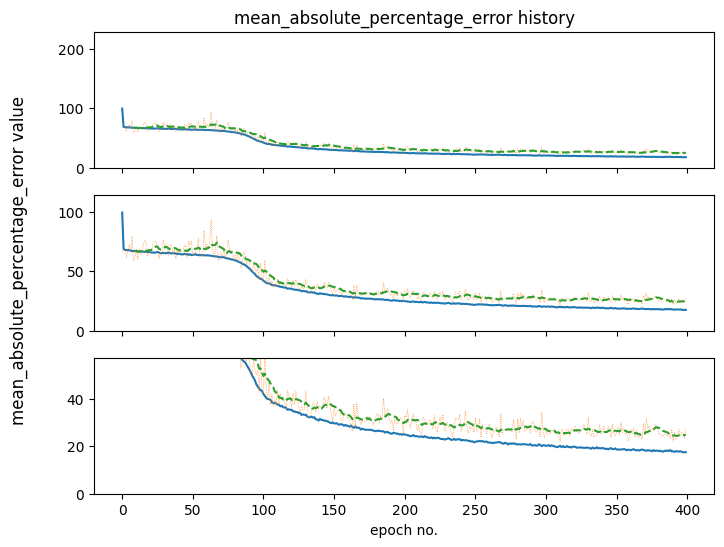

In [18]:
from common.plot import plot_metric_history, plot_metric_history_zoomed
history_df = pd.read_csv(ABS_ROOT_DIR_PATH + 'trained_models/pt/1to10-raw/history/10-4-512-cart_relu-convert_to_real_with_abs-history.csv')

# plot_metric_history_zoomed(history_df)
plot_metric_history_zoomed(history_df, metric = 'mean_absolute_percentage_error',
                           threshold_multiplier = 10, legend_loc = None)